In [65]:
import numpy as np
import marshal, json
import matplotlib.pyplot as plt
import matplotlib
import json, math
import imageio.v2 as imageio
from IPython.display import set_matplotlib_formats
import matplotlib_inline.backend_inline
from IPython.display import Image

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
plt.rcParams.update({
    'font.family': 'serif',
    "font.serif": 'Times',
    'font.size': 12,
    'text.usetex': True,
    'pgf.rcfonts': False,
    'figure.dpi': 300,
    'savefig.dpi': 300
})

########## PARAMS ##########
num_runs = 15
diss_rate_target = 0.99
aoi_target = 0.01
v = 43
frame_count = 10

########## UTIL FUNCTIONS ##########

def is_successful_config(diss_rate, excess_probability, config):
    print(diss_rate[config], excess_probability[config] )
    return diss_rate[config] >= 0.99 and excess_probability[config] <= 0.01


def get_best_config(diss_rate, excess_probability):
    meets_reliability_target = len(diss_rate[diss_rate >= 0.99]) > 0
    if meets_reliability_target:
        candidates = diss_rate >= 0.99
        candidates = (1 - excess_probability) * candidates
        return np.unravel_index(np.argmax(candidates), candidates.shape)
    else:
        return np.unravel_index(np.argmax(diss_rate), diss_rate.shape)


def get_color_map():
    return matplotlib.cm.get_cmap('RdYlGn')

def get_rdf_traffic_density(n,i,q):
    diss_rate = []
    excess_probability = []

    errors = 0
    for r in range(num_runs):
        try:
            with open(f'../res/v{v}_parsed/summary_kpi_rdf_n{n}_i{i}_q{q}_r{r}.json', 'r') as f:
                data = json.load(f)
                diss_rate.append(data['avg_dissemination_rate'])
                excess_probability.append(data['excess_probability_1_R_peak'])
        except:
            errors += 1

    if errors == num_runs:
        return (0,1)
    return (np.mean(diss_rate), np.mean(excess_probability))


def get_sf_traffic_density(n,i,p):
    diss_rate = []
    excess_probability = []
    
    errors = 0
    for r in range(num_runs):
        try:
            with open(f'../res/v{v}_parsed/summary_kpi_sf_n{n}_i{i}_p{p}_r{r}.json', 'r') as f:
                data = json.load(f)
                diss_rate.append(data['avg_dissemination_rate'])
                excess_probability.append(data['excess_probability_1_R_peak'])
        except:
            errors += 1

    if errors == num_runs:
        return (0,1)
    return (np.mean(diss_rate), np.mean(excess_probability))
        


In [66]:
def plot_rdf_kpis(num_nodes, show=False):
    q_list = [0, 100, 110, 120, 130, 140, 150]
    i_list = [30, 60, 90, 120, 150, 180]
    reliability_target = np.zeros((len(q_list), len(i_list)))
    delay_target = np.zeros((len(q_list), len(i_list)))

    for x, q in enumerate(q_list):
        for y, i in enumerate(i_list):
            (diss_rate, excess_probability) = get_rdf_traffic_density(num_nodes, i, q)
            reliability_target[x][y] = diss_rate
            delay_target[x][y] = excess_probability

    fig, ax = plt.subplots()
    fig.tight_layout()

    cmap = get_color_map()
    norm = matplotlib.colors.Normalize(vmin=0.6, vmax=1)

    im = ax.imshow(reliability_target, vmin= 0.6, vmax=1, cmap=cmap)
    cbar = plt.colorbar(im, shrink=0.56, pad=0.02, anchor=(0,0.29), aspect=8, ticks=[0.6, 0.8, 1])
    cbar.set_label("KPI Target Reached")
    cbar.ax.set_yticklabels(['60\%', '80\%', '100\%'], rotation = 90, va='center')
    ax.set_yticks(np.arange(len(q_list)), labels=np.array(q_list) / 100)
    ax.set_xticks(np.arange(len(i_list)), labels=i_list)
    ax.set_xlabel('Send Interval [ms]')
    ax.set_ylabel('Decay Factor $q$')
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.spines.left.set_visible(False)
    ax.spines.bottom.set_visible(False)

    t1 = plt.Rectangle((7.7, -0.5), 1, 1, fill=False, ec='#333', lw=1, clip_on=False)
    path = matplotlib.path.Path([[8.7, -0.5], [7.7, 0.5]])
    t2 = matplotlib.patches.PathPatch(path, ec='#333', lw=1, clip_on=False) 
    plt.gca().add_patch(t1)
    plt.gca().add_patch(t2)
    upper_text = '$P_\mathrm{D}$'
    lower_text = '$P_\mathrm{EX}$'
    ax.text(8.2, 0, f'{upper_text}\n{lower_text}', ha="center", va="center", color="#333", rotation=45, fontsize=12, linespacing=2 )
    ax.text(8.2, 6.15, f'$n={num_nodes}$', ha="center", va="center", color="#333", fontsize=12)

    for i in range(len(i_list)):
        for j in range(len(q_list)):
            t1 = plt.Polygon([[i + 0.5,j-0.5],[i+0.5,j+0.5],[i-0.5,j+0.5]], color=cmap(norm(1-delay_target[j,i])), lw=0)
            plt.gca().add_patch(t1)
            upper_text = '$\geq 99$' if reliability_target[j, i] >= 0.99 else f'${min(1, reliability_target[j, i]- 0.0005) * 100:.1f}$'
            lower_text = '$\leq 1$' if  delay_target[j, i] <= 0.01 else f'${min(1, delay_target[j, i]+ 0.0005) * 100:.1f}$'
            text = ax.text(i, j, f'{upper_text}\n{lower_text}', ha="center", va="center", color="w", rotation=45, fontsize=12, linespacing=2 )

    for i in range(len(i_list)):
        for j in range(len(q_list)):
            if (reliability_target[j, i] >= 0.99) and (delay_target[j, i] <= 0.01):
                t1 = plt.Rectangle((i - 0.5, j - 0.5 ), 1, 1, fill=False, ec='#FFF', lw=1, clip_on=False)
                plt.gca().add_patch(t1)


    best = get_best_config(reliability_target, delay_target)
    success = is_successful_config(reliability_target, delay_target, best)
    t1 = plt.Rectangle((best[1] - 0.5, best[0] - 0.5 ), 1, 1, fill=False, ec='#7eb0d5' if success else '#fd7f6f', lw=2, clip_on=False)
    plt.gca().add_patch(t1)


    plt.title('Dissemination Rate $P_\mathrm{D}$ \& AoI Excess Probability $P_\mathrm{EX}$ (RDF)')
    fig.savefig(f"../figures/kpis_rdf_n{num_nodes}_v{v}.pdf", dpi=500, bbox_inches='tight', pad_inches=0.01)
    fig.savefig(f"../figures/kpis_rdf_n{num_nodes}_v{v}.png", dpi=500, bbox_inches='tight', pad_inches=0.01)
    if show:
        plt.show()
    else:
        plt.close()

    return (reliability_target, delay_target, best)

In [67]:
def plot_sf_kpis(num_nodes, show=False):
    p_list = [100, 90, 80, 70, 60, 50, 45, 40]
    i_list = [30, 60, 90, 120, 150, 180]
    reliability_target = np.zeros((len(p_list), len(i_list)))
    delay_target = np.zeros((len(p_list), len(i_list)))

    for x, p in enumerate(p_list):
        for y, i in enumerate(i_list):
            (diss_rate, excess_probability) = get_sf_traffic_density(num_nodes, i, p)
            reliability_target[x][y] = diss_rate
            delay_target[x][y] = excess_probability

    fig, ax = plt.subplots()
    fig.tight_layout()

    cmap = get_color_map()
    norm = matplotlib.colors.Normalize(vmin=0, vmax=1)

    im = ax.imshow(reliability_target, vmin= 0, vmax = 1, cmap=cmap)
    cbar = plt.colorbar(im, shrink=0.56, pad=0.02, anchor=(0,0.29), aspect=8, ticks=[0, 0.5, 1])
    cbar.set_label("KPI Target Reached")
    cbar.ax.set_yticklabels(['0\%', '50\%', '100\%'], rotation = 90, va='center')
    ax.set_yticks(np.arange(len(p_list)), labels=np.array(p_list) / 100)
    ax.set_xticks(np.arange(len(i_list)), labels=i_list)
    ax.set_xlabel('Send Interval [ms]')
    ax.set_ylabel('Forwarding Probability $p$')
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.spines.left.set_visible(False)
    ax.spines.bottom.set_visible(False)

    t1 = plt.Rectangle((8.7, -0.5), 1, 1, fill=False, ec='#333', lw=1, clip_on=False)
    path = matplotlib.path.Path([[9.7, -0.5], [8.7, 0.5]])
    t2 = matplotlib.patches.PathPatch(path, ec='#333', lw=1, clip_on=False) 
    plt.gca().add_patch(t1)
    plt.gca().add_patch(t2)
    upper_text = '$P_\mathrm{D}$'
    lower_text = '$P_\mathrm{EX}$'
    ax.text(8.2, 0, f'{upper_text}\n{lower_text}', ha="center", va="center", color="#333", rotation=45, fontsize=12, linespacing=2 )
    ax.text(8.2, 6.15, f'$n={num_nodes}$', ha="center", va="center", color="#333", fontsize=12)

    for i in range(len(i_list)):
        for j in range(len(p_list)):
            t1 = plt.Polygon([[i + 0.5,j-0.5],[i+0.5,j+0.5],[i-0.5,j+0.5]], color=cmap(norm(1- delay_target[j,i])), lw=0)
            plt.gca().add_patch(t1)
            upper_text = '$\geq 99$' if reliability_target[j, i] >= 0.99 else f'${min(1, reliability_target[j, i]) * 100:.1f}$'
            lower_text = '$\leq 1$' if  delay_target[j, i] <= 0.01 else f'${min(1, delay_target[j, i]) * 100:.1f}$'
            text = ax.text(i, j, f'{upper_text}\n{lower_text}', ha="center", va="center", color="w", rotation=45, fontsize=12, linespacing=2 )

    for i in range(len(i_list)):
        for j in range(len(p_list)):
            if (reliability_target[j, i] >= 0.99) and (delay_target[j, i] <= 0.01):
                t1 = plt.Rectangle((i - 0.5, j - 0.5 ), 1, 1, fill=False, ec='#ffffff', lw=1, clip_on=False)
                plt.gca().add_patch(t1)

    best = get_best_config(reliability_target, delay_target)
    print(best)
    success = is_successful_config(reliability_target, delay_target, best)
    t1 = plt.Rectangle((best[1] - 0.5, best[0] - 0.5 ), 1, 1, fill=False, ec='#7eb0d5' if success else '#fd7f6f', lw=2, clip_on=False)
    plt.gca().add_patch(t1)
    
    plt.title('Dissemination Rate $P_\mathrm{D}$ \& AoI Excess Probability $P_\mathrm{EX}$\n(PF \& SF)')
    fig.savefig(f"../figures/kpis_sf_n{num_nodes}_v{v}.pdf", dpi=500, bbox_inches='tight', pad_inches=0.01)
    fig.savefig(f"../figures/kpis_sf_n{num_nodes}_v{v}.png", dpi=500, bbox_inches='tight', pad_inches=0.01)
    if show:
        plt.show()
    else:
        plt.close()

In [68]:
def plot_rdf_gif():
    with imageio.get_writer(f'../figures/kpis_rdf_v{v}.gif', mode='I') as writer:
        for n in range(100, 500, 50):
            plot_rdf_kpis(n)
            image = imageio.imread(f'../figures/kpis_rdf_n{n}_v{v}.png')
            for k in range(frame_count):
                writer.append_data(image)


#Image(filename=f"../figures/kpis_rdf_v{v}.gif")

In [69]:
def plot_sf_gif():
    with imageio.get_writer(f'../figures/kpis_sf_v{v}.gif', mode='I') as writer:
        for n in range(100, 500, 20):
            plot_sf_kpis(n)
            image = imageio.imread(f'../figures/kpis_sf_n{n}_v{v}.png')
            for k in range(frame_count):
                writer.append_data(image)


#Image(filename=f"../figures/kpis_sf_v{v}.gif")

(6, 1)
0.9912698571428572 0.0013855371428571426


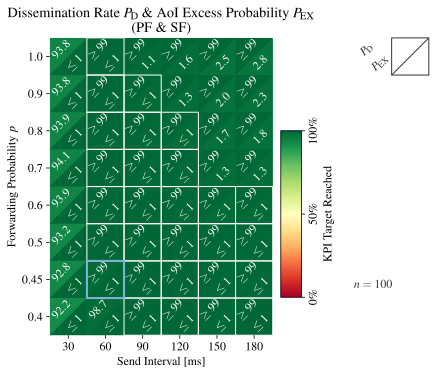

In [70]:
#plot_sf_gif()
#plot_rdf_gif()
plot_sf_kpis(100, True)

In [71]:
# plot_rdf_kpis(220, True)

In [72]:
print(get_sf_traffic_density(220, 420, 100))

(0, 1)
